In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
#Load Data

In [3]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

In [4]:
train.head()

,row_id,x,y,accuracy,time,place_id
0,0,0.7941,9.0809,54,470702,8523065625
1,1,5.9567,4.7968,13,186555,1757726713
2,2,8.3078,7.0407,74,322648,1137537235
3,3,7.3665,2.5165,65,704587,6567393236
4,4,4.0961,1.1307,31,472130,7440663949


In [24]:
########################### Basic Data Exploration ######################################

In [25]:
print("# of Observations: {0}".format(len(train)))
print("# of Check-in Locations: {0}".format(len(train['place_id'].unique())))

# of Observations: 29118021
# of Check-in Locations: 108390


In [26]:
#That's a pretty large amount of data and a very large classificaiton problem
#Let's see how popular each check-in location is.
#If some locations are very unpopular, we could dump them to make classification more efficient.

In [27]:
place_count = train[['place_id','time']].groupby(by='place_id').count()
place_count = place_count.sort('time')
place_count = place_count.rename(columns={'time':'count'})

/Users/williammcgehee/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:2: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  from ipykernel import kernelapp as app


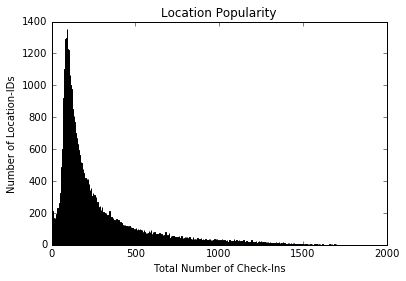

In [28]:
plt.hist(place_count['count'],bins=1000)
plt.title("Location Popularity")
plt.xlabel("Total Number of Check-Ins")
plt.ylabel("Number of Location-IDs")
plt.show()

In [29]:
#There are a few check-in locations that are not very popular.
#However, it doesn't look like there are enough to give a big boost to efficiency.

In [30]:
#Let's move on and try to get an intuition for what this 'map' looks like.
#There's an enormous number of locations so to avoid a jungle of spots let's plot the most
#popular locations.

In [31]:
popular_places = place_count.tail().index.values

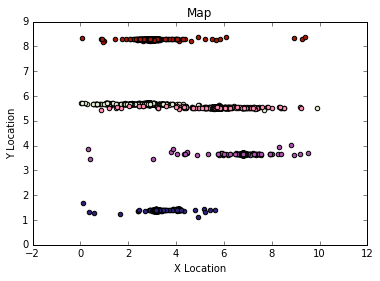

In [32]:
for i in range(0,len(popular_places)):
    sample = train[train.place_id==popular_places[i]]
    rand_color = (np.random.uniform(0,1),np.random.uniform(0,1),np.random.uniform(0,1))
    plt.scatter(sample['x'],sample['y'],c=rand_color)
plt.title('Map')
plt.xlabel('X Location')
plt.ylabel('Y Location')
plt.show()

In [33]:
#That's very strange. Looks like there's huge variance on the x axis and much less on the y.
#I wonder if this is the case for all locations

In [34]:
place_variance = train.groupby('place_id').var()

In [35]:
place_variance.describe()

,row_id,x,y,accuracy,time
count,1.081440e+05,1.081440e+05,108144.000000,108144.000000,1.081440e+05
mean,7.067331e+13,7.303021e-01,0.001162,13035.425851,4.118669e+10
std,7.185711e+12,1.295864e+00,0.021275,10350.123452,1.971278e+10
min,6.395676e+08,2.450000e-07,0.000000,0.000000,2.000000e+00
25%,6.754424e+13,1.211701e-01,0.000128,7105.322827,2.693675e+10
50%,7.060546e+13,3.118647e-01,0.000205,11093.275613,4.841864e+10
75%,7.368541e+13,7.328495e-01,0.000455,16336.629676,5.524567e+10
max,3.534458e+14,3.357901e+01,4.606220,457924.500000,2.976108e+11


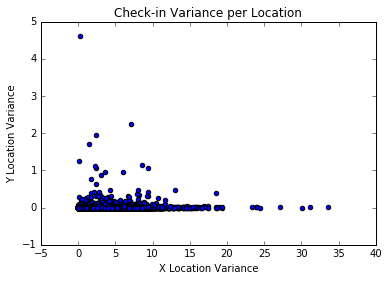

In [36]:
plt.scatter(place_variance['x'],place_variance['y'])
plt.title("Check-in Variance per Location")
plt.xlabel('X Location Variance')
plt.ylabel('Y Location Variance')
plt.show()

In [37]:
#In the above graph, each dot represents a location id. 
#It seems that there is a lot more variance overall in the x-location than in the y-location

In [38]:
#Let's explore the Accuracy Variable. Maybe this could help explain the x_axis variance.
#I assume accuracy means the x and y locations of the check-in are closer to the 'real' location.

In [39]:
train['accuracy'].describe()

count    2.911802e+07
mean     8.284912e+01
std      1.147518e+02
min      1.000000e+00
25%      2.700000e+01
50%      6.200000e+01
75%      7.500000e+01
max      1.033000e+03
Name: accuracy, dtype: float64

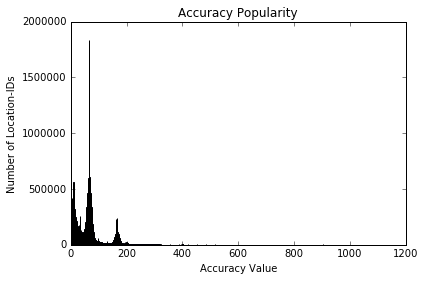

In [40]:
plt.hist(train['accuracy'],1000)
plt.xlabel('Accuracy Value')
plt.ylabel('Number of Location-IDs')
plt.title('Accuracy Popularity')
plt.show()

In [41]:
#Interesting that 75% of the accuracy values are under 75 and yet the max is 1033. 
#Interesting tri-modal distribution.

In [42]:
#Let's see if the variance of location can be explained somehow by the accuracy
#Let's cut down the mean and split the data into a high accuracy group and a low accuracy group

In [43]:
low_accuracy_data = train[train.accuracy<np.mean(train['accuracy'])]
high_accuracy_data = train[train.accuracy>np.mean(train['accuracy'])]

In [44]:
low_accuracy_data_variance = low_accuracy_data.groupby('place_id').var()
high_accuracy_data_variance = high_accuracy_data.groupby('place_id').var()

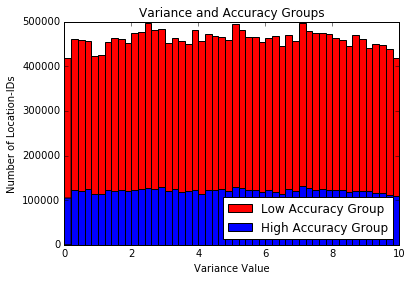

In [45]:
plt.hist(low_accuracy_data['x'].dropna(),bins=50,color='r',label='Low Accuracy Group')
plt.hist(high_accuracy_data['x'].dropna(),bins=50,color='b',label='High Accuracy Group')
plt.xlabel('Variance Value')
plt.ylabel('Number of Location-IDs')
plt.title('Variance and Accuracy Groups')
plt.legend(loc=4)
plt.show()

In [46]:
#It looks like a uniform distribution of variance between the two accuracy group.
#If accuracy was important I would have expected a leftward skew on the high accuracy group
#and a rightward skew on the low accuracy group.
#This is evidence that accuracy is not helpful in explaining location variance.

In [47]:
#Let's look at time

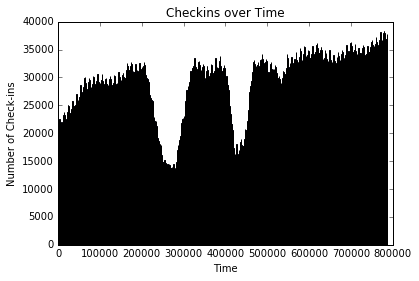

In [48]:
plt.hist(train['time'],bins=1000)
plt.xlabel('Time')
plt.ylabel('Number of Check-ins')
plt.title('Checkins over Time')
plt.show()

In [49]:
#Ok there's definitely some information here. 
#There's two big drop offs and overall a slight upward trend over time

In [50]:
#Let's plot check-ins in 3-D using time as an axis to get an intuition for what time is doing.

In [51]:
from mpl_toolkits.mplot3d import Axes3D

In [52]:
def plot_3D(data):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.set_xlabel('X Location')
    ax.set_ylabel('Y Location')
    ax.set_zlabel('Time')
    
    for place in data['place_id'].unique():
        p_slice = data[data.place_id==place]
        X = p_slice['x']
        Y = p_slice['y']
        Z = p_slice['time']
        color = (np.random.uniform(0,1),np.random.uniform(0,1),np.random.uniform(0,1))
        ax.scatter(X,Y,Z,c=color)    
    plt.show()

In [53]:
#Obviously we'll need to look at a small subset of the data avoid a dot ocean
#Let's define a function that will automatically give us a sub-view of the map

In [5]:
def get_subview(x_min, x_max, y_min, y_max, data):
    return data[data.x>x_min][data.x<x_max][data.y>y_min][data.y<y_max]

In [6]:
a_slice = get_subview(0,0.1,0,0.1,train)

/Users/williammcgehee/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  from ipykernel import kernelapp as app


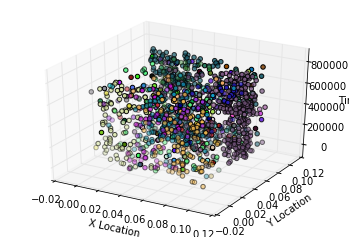

In [56]:
plot_3D(a_slice)

In [57]:
#It's hard to tell but generally seems time is a useful diminsion

In [58]:
########################### Classification Attempts ##################################

In [ ]:
#The problem with a stright forward classfication is that the data set is so huge
#runtime becomes a serious issue. In order to speed up runtime, we need to divide
#the map into a grid and use each grid to make predictions within that grid.

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn import preprocessing

In [ ]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

In [ ]:
#Normalise
train['x'] = train['x']/np.max(train['x'])
train['y'] = train['y']/np.max(train['y'])
train['time'] = train['time']/np.max(train['time'])

test['x'] = test['x']/np.max(test['x'])
test['y'] = test['y']/np.max(test['y'])
test['time'] = test['time']/np.max(test['time'])

In [ ]:
def get_subview(x_min, x_max, y_min, y_max, data):
    return data[(data.x>x_min) & (data.x<x_max) & (data.y>y_min) & (data.y<y_max)]

In [ ]:
def grid_predict(train_grid, test_grid):
    indep_cols = ['x','y','time']
    dep_cols = ['encoded_pred']
    
    LE = preprocessing.LabelEncoder()
    train_grid.loc[:,"encoded_pred"]=LE.fit_transform(train_grid.loc[:,"place_id"])

    
    RF = RandomForestClassifier(n_estimators=120,n_jobs=-1)
    RF.fit(train_grid.loc[:,indep_cols],train_grid.loc[:,dep_cols])
    prediction = RF.predict_proba(test_grid.loc[:,indep_cols])
    
    test_grid_prediction = LE.inverse_transform(np.argsort(prediction,axis=1)[:,::-1][:,:3])
    return test_grid_prediction

In [ ]:
def grid_classify(train,test):
    grid_length = 0.01
    x_coord = 1/grid_length
    y_coord = 1/grid_length
    prediction = np.empty((0,4))
    for i in range(0,int(x_coord)):
        for y in range(0,int(y_coord)):
            x_min = i*grid_length
            x_max = i*grid_length+grid_length
            y_min = y*grid_length
            y_max = y*grid_length+grid_length
            train_grid = get_subview(x_min, x_max, y_min, y_max, train)
            test_grid = get_subview(x_min, x_max, y_min, y_max, test)
            grid_pred = grid_predict(train_grid,test_grid)
            pred_norm = np.append(test_grid.row_id.values.reshape(len(test_grid),1),grid_pred,axis=1)
            prediction = np.vstack((prediction,pred_norm))
    return pd.DataFrame(prediction,columns=["row_id","pred1","pred2","pred3"])

In [ ]:
def generate_sub(preds):    
    preds = preds.sort_values(by="row_id")
    preds[["pred1","pred2","pred3"]]=preds[["pred1","pred2","pred3"]].astype(int)
    
    df_aux = pd.DataFrame(preds, dtype=str, columns=['pred1', 'pred2', 'pred3'])
    #Concatenating the 3 predictions for each sample
    ds_sub = df_aux.pred1.str.cat([df_aux.pred2, df_aux.pred3], sep=' ')
    ds_sub.index=preds.row_id.astype(int)

    #Writting to csv
    ds_sub.name = 'place_id'
    ds_sub.to_csv('./Submission.csv', index=True, header=True, index_label='row_id')

In [ ]:
predictions = grid_classify(train,test)

In [ ]:
generate_sub(predictions)